In [1]:
import torch
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
table = torch.arange(1 << 8).to(torch.uint8)
mask = 0b10011110

fp8_values = table.view(torch.float8_e4m3fn).float()
fp8_values = fp8_values[~torch.isnan(fp8_values)]

bits = table & mask
fp8_values_masked = bits.view(torch.float8_e4m3fn).float()

In [3]:
# unique = fp8_values.unique()
# for unique_val in unique:
#     print(unique_val, sum(fp8_values==unique_val))

In [4]:
def plot_hist_vs_normal(x, n_bins=16, figsize=(4, 3)):
    plt.figure(figsize=figsize)

    mu, std = x.mean(), x.std()
    normal_samples = torch.normal(mu, std, (10**4,))
    
    plt.hist(x.numpy(), bins=n_bins, density=True, alpha=0.7, label='x')
    plt.hist(normal_samples.numpy(), bins=n_bins, density=True, alpha=0.7, label='Normal')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

In [5]:
def qq_plot(tensor: torch.Tensor, figsize=(4, 3)):
    """
    Create Q-Q plot for torch tensor against normal distribution.
    
    Parameters:
    tensor: torch.Tensor - input tensor
    figsize: tuple - figure size
    """
    tensor_np = tensor.cpu().numpy().flatten()
    
    plt.figure(figsize=figsize)
    stats.probplot(tensor_np, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.grid(True, alpha=0.2)
    
    # Добавим справочную информацию
    skewness = stats.skew(tensor_np)
    kurtosis = stats.kurtosis(tensor_np, fisher=True)
    
    plt.figtext(0.02, 0.02, f"Skewness: {skewness:.3f}\nExcess Kurtosis: {kurtosis:.3f}", 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.show()


def kolmogorov_smirnov_test(tensor: torch.Tensor):
    tensor_np = tensor.cpu().numpy().flatten()
    tensor_normalized = (tensor_np - tensor_np.mean()) / tensor_np.std()
    ks_statistic, p_value = stats.kstest(tensor_normalized, 'norm')
    results = {
        'ks_statistic': round(ks_statistic.item(), 4),
        'p_value': round(p_value.item(), 4)
    }
    return results

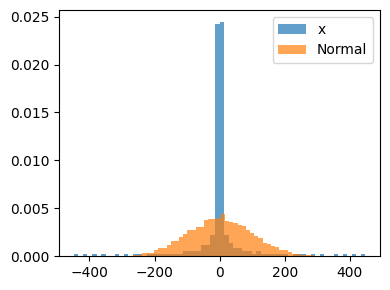

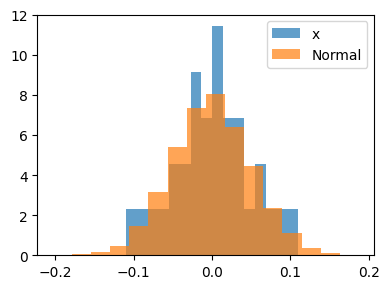

In [6]:
plot_hist_vs_normal(fp8_values, n_bins=64)
plot_hist_vs_normal(fp8_values_masked)

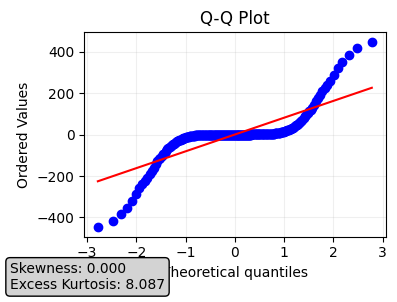

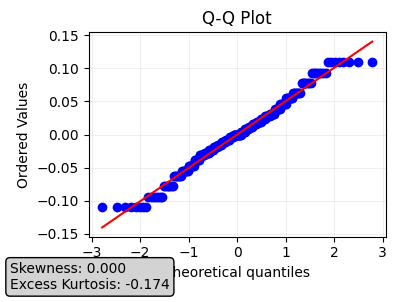

In [7]:
qq_plot(fp8_values)
qq_plot(fp8_values_masked)

In [17]:
normal = torch.randn_like(fp8_values_masked)

print(kolmogorov_smirnov_test(normal))
print(kolmogorov_smirnov_test(fp8_values))
print(kolmogorov_smirnov_test(fp8_values_masked))


{'ks_statistic': 0.0435, 'p_value': 0.6998}
{'ks_statistic': 0.287, 'p_value': 0.0}
{'ks_statistic': 0.0487, 'p_value': 0.5608}
